# Generalized Network Analysis Tutorial - Step 2

In the second part of our generalized network analysis tutorial, the user is presented with another jupyter notebook where all the correlation maps calculated in the first part can be translated into molecular visualizations or plots. Here we provide an opportunity for users more comfortable with python programming to tailor the analysis to their specific scientific questions.

The Network Analysis Tutorial is part of the work entitled **Generalized correlation-based dynamical network analysis: a new high-performance approach for identifying allosteric communications in molecular dynamics trajectories**, by Marcelo C. R. Melo, Rafael C. Bernardi, Cesar de la Fuente-Nunez, and Zaida Luthey-Schulten. For more information see http://faculty.scs.illinois.edu/schulten/. 

In [1]:
# Load the python package
import os
# import dynetan
from dynetan.toolkit import *
from dynetan.viz import *
from dynetan.proctraj import *
from dynetan.gencor import *
from dynetan.contact import *
from dynetan.datastorage import *

#from numpy.linalg import norm
from itertools import islice
from scipy import stats

import pandas as pd
import numpy as np
import scipy as sp

# For visualization
import nglview    as nv
import ipywidgets as widgets

In [2]:
dnad = DNAdata()

In [3]:
# Allows better plotting inside jupyter notebooks
%matplotlib notebook

In [4]:
# !pip install rpy2
# import rpy2.ipython
%load_ext rpy2.ipython

In [5]:
# Make sure all the following packages are installed in your R distribution

%R require(data.table)
%R require(ggplot2)
%R require(ggrepel)
%R require(gdata)
%R require(RColorBrewer)
%R require(colorRamps)
%R require(rPref)

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggrepel

R[write to console]: Loading required package: gdata

R[write to console]: Loading required package: RColorBrewer

R[write to console]: Loading required package:

0


In [6]:
# import rpy2's package module
# import rpy2.robjects.packages as rpackages

# # import R's utility package
# utils = rpackages.importr('utils')

# # select a mirror for R packages
# utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# print(utils.chooseCRANmirror())

In [7]:
# R package names
# packnames = ('data.table','ggplot2', 'ggrepel', 'gdata','RColorBrewer', 'colorRamps', 'rPref')

# # R vector of strings
# from rpy2.robjects.vectors import StrVector

# # Selectively install what needs to be install.
# # We are fancy, just because we can.
# names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
# if len(names_to_install) > 0:
#     utils.install_packages(StrVector(names_to_install))

## Files and system definitions (same as in "ProcessTrajectory" notebook) 

Make sure that all the paths are the same as in the **Step 1** notebook. Also, you might want to have analysis resutls saved to a new location, to avoid mixing results of different systems. If you are copying this tutorial to adapt to your own system, be careful to select new paths. 

In [7]:
dataDir = "/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA"

# Path where results will be written (you may want plots and data files in a new location)
workDir = "/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA"

fileNameRoot = "tgRNA_network"
fullPathRoot = os.path.join(dataDir, fileNameRoot)

# Define the segID of the Ligand being studied.
ligandSegID = "SYST"

In [9]:
# s = np.load(os.path.join(dataDir, "crRNA_network_nodesComm.npy"), allow_pickle=True)
# print(s.shape)
# print(s)

In [10]:
# s = np.load(os.path.join(dataDir, "crRNA_network_btws.npy"), allow_pickle=True)
# print(s.shape)
# print(s)

In [8]:
# Creates the workdirectory, and Plots directory.
# import os
# if not os.path.exists(workDir):
#     os.makedirs(workDir)
# os.makedirs(os.path.join(workDir, "Plots"))

## Load the Data

In [8]:
dnad.loadFromFile(fullPathRoot)

atomToNode int64 (22410,) 22410
contactMat int64 (1241, 1241) 1540081
contactNodesInter int64 (0,) 0
corrMatAll float64 (1, 1241, 1241) 1540081
distsAll float64 (1, 1241, 1241) 1540081
interNodePairs int64 (0,) 0
maxDirectDist float64 () 1
maxDist float64 () 1
nodeDists float64 (4, 769420) 3077680
nodesIxArray int64 (1241,) 1241
numNodes int32 () 1


Load reduced trajectory, in case this notebook did not load ALL trajectories.

In [9]:
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"

workUviz = mda.Universe(pdbVizFile, dcdVizFile)

If we are loading the first trajectory of the notebook, we need to create the dnad.nodesAtmSel structure to make selections on the universe based on node indices. This is mostly used for visualizations.

In [10]:
# We add this to the object for ease of access.
dnad.nodesAtmSel = workUviz.atoms[ dnad.nodesIxArray ]

In [11]:
print(dnad.nodesAtmSel)

<AtomGroup [<Atom 5: CA of type C of resname MET, resid 1 and segid SYST and altLoc >, <Atom 22: CA of type C of resname LYS, resid 2 and segid SYST and altLoc >, <Atom 44: CA of type C of resname VAL, resid 3 and segid SYST and altLoc >, ..., <Atom 22315: P of type P of resname G, resid 1239 and segid SYST and altLoc >, <Atom 22349: P of type P of resname U, resid 1240 and segid SYST and altLoc >, <Atom 22379: P of type P of resname C3, resid 1241 and segid SYST and altLoc >]>


In [12]:
trgtNodes = getNodeFromSel("segid " + ligandSegID + " and resid 1212:1241", dnad.nodesAtmSel, dnad.atomToNode)
trgtNode = getNodeFromSel("segid " + ligandSegID + " and name P N9 N1", dnad.nodesAtmSel, dnad.atomToNode)
print(trgtNodes, trgtNode)

[1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224
 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238
 1239 1240] [1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208
 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222
 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236
 1237 1238 1239 1240]


## Analyze Communitites (Run the following cells so that in next steps we can use the embedded network object.. I exactly don't know what are the required data and what are the optional data for their embedded object to work.. so just run the following cells or explore alternatives without running these  )
We keep the communities that have more than 1% of nodes in all windows. Then we group communities across replicas by largest intersection. This is needed because we have no guarantee that the same community will be assigned the same ID in different windows of the same simulation.

We fin ally rank the communities by modularity.

** The "nodeCommNP" list created in the following section will be used to calculate inter-domain and inter-community betweennesses later

In [13]:
import networkx.algorithms.community.quality as nxquality

# Creates a list of windows and order them according to graph modularity.
windModul = []
for window in range(dnad.numWinds):
    modul = nxquality.modularity(dnad.nxGraphs[window], 
                         [ set(nodesList) for nodesList in dnad.nodesComm[window]["commNodes"].values()])
    windModul.append((window, modul))
    
windModul.sort(key=lambda x:x[1], reverse=True)

# Keep the window with the highest modularity as a reference for community matching
refWindow = windModul[0][0]

for wind, mod in windModul[:5]:
    print( "Window {} has modularity {:1.4f}.".format(wind, mod) )

Window 0 has modularity 0.8223.


In [14]:
cutoff = max(10, np.ceil(0.01*dnad.numNodes))

def matchComm(mCommID, mWindow, refWindow, dnad, cutoff=1):
    """
    Returns the community ID for the reference window that has the largest
    intersection with the matching community at the matching window.
    Communities at the reference window with less than *cutoff* percent of nodes
    are ignored.
    """
    
    trgtComm = -1
    intersectSize = 0
    for commID in dnad.nodesComm[refWindow]["commOrderSize"]:
        # Skip community if it has less than one percent of the nodes.
        commSize = len(dnad.nodesComm[refWindow]["commNodes"][commID])
        if commSize < cutoff:
            continue
        
        tmpSize = len( set(dnad.nodesComm[refWindow]["commNodes"][commID]).intersection( 
            set(dnad.nodesComm[mWindow]["commNodes"][mCommID]) ) )
        
        # Selects the largets intersection
        if intersectSize < tmpSize:
            intersectSize = tmpSize
            trgtComm = commID
    
    return trgtComm, intersectSize

print("Using reference window {0} with highest modularity {1:<1.4}".format(*windModul[0]))

communities = defaultdict(list)
for window in range(dnad.numWinds):
    for commID in dnad.nodesComm[window]["commOrderSize"]:
        
        # Skip community if it has less than one percent of the nodes.
        commSize = len(dnad.nodesComm[window]["commNodes"][commID])
        if commSize < cutoff:
            continue
        
        matchID, interSize = matchComm(commID, window, refWindow, dnad, cutoff)
        
        communities[matchID].append( (commID, interSize, window) )
        
communities = {key:val for (key,val) in communities.items() }
communities.keys()

# Creates a list of communities ID from the dictionary keys
# Orders the keys according to mean intersection size over all windows.
tmpList = []
for key,val in communities.items():
    tmpList.append((key, np.mean([pair[1] for pair in val]), len(val)))
tmpList.sort(key=lambda x:x[1], reverse=True)
tmpList

# Creates a pandas data frame for plotting and analysis
commList = []
genCommID = 0
for key in [x[0] for x in tmpList]:
    val = communities[key]
    for valList in val:
        commList.append( [genCommID, *valList ] )
    genCommID += 1

commDF = pd.DataFrame(data=commList, columns=["genCommID","commID","interSize","Window"])

Using reference window 0 with highest modularity 0.8223


In [15]:
# Changes "genCommID" for communities that are matched to the same community in the reference window.
c = commDF.groupby(["genCommID","Window"]).cumcount()
c *= 0.1
commDF[ "genCommID" ] += c

In [16]:
# Creates a NumPy 2D array to organize data and transform it in a pandas DF.
# Not pretty but its pynthon...
nodeCommNP = np.empty([dnad.numNodes, dnad.numWinds])
nodeCommNP.fill(-1)

#Group by general community ID
grpBy = commDF.groupby("genCommID")
for genCommID, group in grpBy:
    for winIndx,commID in group[["Window","commID"]].values:
        for node in range(dnad.numNodes):
            if dnad.nxGraphs[winIndx].nodes[node]["modularity"] == commID:
                nodeCommNP[node, winIndx] = genCommID

In [17]:
# Removes nodes that were not classified in a "big-nough" (bigger than 1%) cluster in *any* window.
nodeCommDF = pd.DataFrame(data=nodeCommNP,columns=["Window"+str(i) for i in range(dnad.numWinds)])
nodeCommDF["Node"] = [i for i in range(dnad.numNodes)]
nodeCommDF = nodeCommDF[ nodeCommDF.min(1) >= 0]
# So we don't get "blank"/empty areas in the plot
nodeCommDF["NodePlot"] = [i for i in range(len(np.unique(nodeCommDF["Node"])))]

In [18]:
# Checks that target nodes are classified in ALL windows
nodeCommDF.loc[ nodeCommDF["Node"].isin(trgtNodes) ]

,Window0,Node,NodePlot
1211,7.0,1211,1211
1212,7.0,1212,1212
1213,7.0,1213,1213
1214,7.0,1214,1214
1215,7.0,1215,1215
1216,7.0,1216,1216
1217,7.0,1217,1217
1218,7.0,1218,1218
1219,7.0,1219,1219
1220,7.0,1220,1220


In [19]:
# Melts for plotting.
nodeCommDFmelt = nodeCommDF.melt(id_vars=["Node","NodePlot"], value_name="Cluster", var_name="Window")
# Makes it easier to plot
nodeCommDFmelt["Cluster"] = nodeCommDFmelt["Cluster"].astype('category')
# Makes it easier to plot
for i in range(dnad.numWinds):
    nodeCommDFmelt.replace("Window"+str(i),i, inplace=True)

In [20]:
nodeCommDFmelt.loc[nodeCommDFmelt["Node"].isin(trgtNodes)].groupby("Node")["Cluster"].apply(np.unique)

Node
1211     [7.0]
1212     [7.0]
1213     [7.0]
1214     [7.0]
1215     [7.0]
1216     [7.0]
1217     [7.0]
1218     [7.0]
1219     [7.0]
1220     [7.0]
1221     [7.0]
1222     [7.0]
1223     [7.0]
1224     [5.0]
1225     [5.0]
1226     [5.0]
1227     [5.0]
1228     [9.0]
1229     [9.0]
1230     [9.0]
1231     [9.0]
1232     [9.0]
1233     [9.0]
1234     [9.0]
1235    [11.0]
1236    [11.0]
1237    [11.0]
1238     [8.0]
1239     [8.0]
1240     [8.0]
Name: Cluster, dtype: object

In [21]:
trgtClusters = np.unique( nodeCommDFmelt.loc[nodeCommDFmelt["Node"].isin(trgtNodes), "Cluster"].values )
trgtClusters

array([ 5.,  7.,  8.,  9., 11.])

In [22]:
# Add readable info to nodes
def getTagStr(i):
    # Store atom names for residues with multiple nodes
    if len(getNodeFromSel( getSelFromNode(i, dnad.nodesAtmSel), dnad.nodesAtmSel, dnad.atomToNode)) > 1:
        atmStr = ":" + dnad.nodesAtmSel.atoms[i].name
    else:
        atmStr = ""
        
    retStr = dnad.nodesAtmSel.atoms[i].resname.capitalize() + \
            ":" + str(dnad.nodesAtmSel.atoms[i].resid) + \
            atmStr + \
            "_" + dnad.nodesAtmSel.atoms[i].segid
            
    return retStr

nodeCommDFmelt['resid']     = np.vectorize(getTagStr)(nodeCommDFmelt["Node"])

In [31]:
# Write data for Ploting (plots from ggplot in R are much better!)
nodeCommDFmelt.to_csv(os.path.join(workDir, "cluster.csv"),index=False)

In [23]:
# Get all nodes that make contact with target nodes in any window
contactNodes = np.unique( np.where( dnad.corrMatAll[:,trgtNodes,:] > 0 )[2] )
contactNodesTrgts = list(trgtNodes)
for node in contactNodes:
    if len( set(trgtClusters).intersection( 
            set(np.unique(nodeCommDFmelt.loc[ nodeCommDFmelt["Node"] == node].Cluster)) ) ) :
        contactNodesTrgts.append(node)

# Save data to file
# pd.DataFrame(contactNodesTrgts, columns=["contactNodesTrgts"]).to_csv(
#     os.path.join(workDir, "contactNodesTrgts.csv"),index=False)

# pd.DataFrame(trgtNodes, columns=["trgtNodes"]).to_csv(
#     os.path.join(workDir, "trgtNodes.csv"),index=False)

### Prepare pandas data frame with community data

In [24]:
# # Prepares variable names for multi-system comparisons. In this tutorial, we only have one system.
# system1 = "SYST"
# cDF = nodeCommDFmelt
# cDF["system"] = system1
# refWindow1 = refWindow

In [25]:
# Loads VMD-compatible color scales to match community colors in R plots, NGLView, and VMD figures.
# comColorScale = getCommunityColors()

In [73]:
# %%R -i workDir,refWindow,comColorScale -o colorValues,clusterIDs -w 800 -h 450



# dataPath = file.path(workDir, "cluster.csv")

# dt <- data.table::fread(dataPath)
# clusterIDs = dt[, unique(Cluster)]

# colourCount = length(unique(dt$Cluster))

# # We only have 50 availabl colors
# colourCount <- min(colourCount,50)

# rgbCodes <- data.table(comColorScale)

# colorValues <- sapply(seq(colourCount), function(x) rgb(rgbCodes[x, .(R,G,B) ],  maxColorValue = 255) )

# setorder(dt, Cluster)                      
# colorValues = setNames(colorValues, dt[, unique(Cluster)])
# colorValues           

# print(paste("Creating palette for",colourCount,"clusters"))

[1] "Creating palette for 16 clusters"


In [1]:
# # Builds a color dictionary from the cluster color scale built in R
# colorValDict = {}
# colorValDictRGB = {}
# for key,val in zip(clusterIDs, list(colorValues)):
#     colorValDict[key] = val

# for key,val in colorValDict.items():
#     colorValDictRGB[key] = tuple(int(val.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [27]:
print(dnad.nodesAtmSel)

<AtomGroup [<Atom 5: CA of type C of resname MET, resid 1 and segid SYST and altLoc >, <Atom 22: CA of type C of resname LYS, resid 2 and segid SYST and altLoc >, <Atom 44: CA of type C of resname VAL, resid 3 and segid SYST and altLoc >, ..., <Atom 22315: P of type P of resname G, resid 1239 and segid SYST and altLoc >, <Atom 22349: P of type P of resname U, resid 1240 and segid SYST and altLoc >, <Atom 22379: P of type P of resname C3, resid 1241 and segid SYST and altLoc >]>


#### Entire communities:

Second, we show all nodes from a chosen community. The following jupyter notebook cell different options to choose which community is shown. The first will select a community ID and show all nodes. The second allows you to select a set of nodes and show them in the structure.

In [39]:
# w = nv.show_mdanalysis(workUviz.select_atoms("all"))

# w._remote_call("setSize", target="Widget", args=["800px", "600px"])
# w.parameters = dict(theme='light')

# opac = 1

# w.clear_representations()
# w.add_cartoon("protein", color='lightgray', opacity=opac)
# w.add_hyperball(ligandSegID)
# w.add_hyperball("not protein")

# shapeCounter = [0]
# w

In [63]:
# cDF

In [40]:
# Dysplays all nodes of a cluster and colors them by cluster ID.

# clusterID = 0
# showCommunityByID(w, cDF, clusterID, system1, refWindow, shapeCounter, dnad.nodesAtmSel, colorValDictRGB, system1, refWindow1)

In [64]:
# Dysplays a given list of nodes and colors them by cluster ID.

# clusterID = 0
# nodeList = cDF.loc[ (cDF.system == system1) & (cDF.Window == refWindow1) & (cDF.Cluster == clusterID) ].Node.values

# showCommunityByNodes(w, cDF, nodeList, system1, refWindow1, shapeCounter, dnad.nodesAtmSel, colorValDictRGB)

In [65]:
# Color ALL nodes by community

# nodeList = cDF.loc[ (cDF.system == system1) & (cDF.Window == refWindow1) ].Node.values
# showCommunityByNodes(w, cDF, nodeList, system1, refWindow1, shapeCounter, dnad.nodesAtmSel, colorValDictRGB)

In [67]:
# w.(os.path.join(dataDir, "crRNA_community.png"), frame=None)

In [68]:
# w.close()

# Pretty Figures - Preparing files for VMD

The next few steps will define the files that will be created for loading into VMD, a popular molecular visualization software.

**Important:**

Make sure you have all the files created for VMD. For instance, if you are not interested in allosteric communications and suboptimal paths, just select two arbitrary nodes so that the path files are created correctly. Alternatively, you may want to adapt the tcl scripts provided at the end of the notebook to your particular case. 


*** The following files are only for visualizing in VMD (used by "network_view_2.tcl script".. this will be created in a later cell)

** but the normalized correlation matrix created here will be used later

In [32]:
import copy

# This will be used to look for the maximum and  minimum betweenness value in the graph.
# The maximum value will be used ot normalize all betweenness values for better vizualization.
# The minimum value will be used in case a betweenness value could not be assigned for a given edge,
#    also helping visualization.

# Initialize variable with high value.
minimumBetweeness = 100
# Initialize variable with low value.
maximumBetweeness = -1

for pair,btw in dnad.btws[winIndx].items():
    if btw < minimumBetweeness:
            minimumBetweeness = btw
    if btw > maximumBetweeness:
            maximumBetweeness = btw

# Normalize the value.
minimumBetweeness /= maximumBetweeness
            
for winIndx in range(dnad.numWinds):

    normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()
    
    ##########################################################################################
    ### Create PDB file with the system in the first step of each window, for VMD vizualization.
    
    pdbVizFile = os.path.join(workDir, 
                            "tgRNA_networkData_Structure_window_{}.pdb".format(winIndx))
    
    # Calculate number of frames per window.
    winLen = int(np.floor(workUviz.trajectory.n_frames/dnad.numWinds))
    
    # Positions the trajectory at the middle of each window.
    workUviz.trajectory[(winIndx+1)*round(winLen/2)]
    
    with mda.Writer(pdbVizFile, multiframe=False, bonds="conect", n_atoms=workUviz.atoms.n_atoms) as PDB:
        PDB.write(workUviz.atoms)
    
    ##########################################################################################
    ### Create network data file with ALL edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                            "tgRNA_networkData_AllEdges_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:

        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:

            node1 = pair[0]
            node2 = pair[1]

            # Get VMD indices for the atoms
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {}".format(pdbIndx1, pdbIndx2, normCorMat[ node1, node2])
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with ALL NODES, the maximum normalized weight of edges it belongs to,
    ### and the community it belongs to.
    
    fileName = os.path.join(workDir, 
                            "tgRNA_networkData_AllNodes_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for node1 in range(dnad.numNodes):
            
            # Get the VMD index for the atom
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            
            # Get the community the node belongs to
            community1 = int(nodeCommNP[node1, winIndx])
            
            # Find the node to which "node1" is connected with highest correlation.
            node2 = np.where( normCorMat[node1,:] == normCorMat[node1,:].max() )[0][0]
            
            # Skip nodes not assigned to any community
            if community1 < 0:
                continue
            
            string = "{} {} {}".format(pdbIndx1, normCorMat[ node1, node2], community1)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with INTRA-COMMUNITY edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                            "tgRNA_networkData_IntraCommunities_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
            
            node1 = pair[0]
            node2 = pair[1]

            # Checks if both nodes belong to the same community. 
            # If they don't, skip this edge. We only write intra-community edges in this file!
            if nodeCommNP[node1, winIndx] != nodeCommNP[node2, winIndx] :
                continue
            
            # If both nodes do not belong to any community (assigned to community -1), also skip the edge.
            if nodeCommNP[node1, winIndx] < 0:
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            
            # Get VMD indices for the atoms
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {}".format(pdbIndx1, pdbIndx2, normCorMat[ node1, node2], community1)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with INTER-COMMUNITY edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                                "tgRNA_networkData_InterCommunities_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
            
            node1 = pair[0]
            node2 = pair[1]

            # Checks if both nodes belong to the same community. 
            # If they don't, skip this edge. We only write intra-community edges in this file!
            if nodeCommNP[node1, winIndx] == nodeCommNP[node2, winIndx] :
                continue
            
            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                             normCorMat[ node1, node2], community1, community2)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create file with edges listed by betweeness value (highest to lowest).
    
    fileName = os.path.join(workDir, 
                            "tgRNA_networkData_Betweenness_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair,btw in dnad.btws[winIndx].items():
            
            node1 = pair[0]
            node2 = pair[1]

            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                normCorMat[ node1, node2], btw/maximumBetweeness, 
                                                community1, community2)
            
            outfile.write( string + "\n" )


/Users/souviksinha/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [33]:
# print(np.max(nodeCommNP)+1)
# comm_bet = np.zeros(shape=(int(np.max(nodeCommNP)+1), int(np.max(nodeCommNP)+1))) 
# # comm_bet = np.zeros()
# # # running_com =  np.zeros(shape=(np.max(nodeCommNP)+1, np.max(nodeCommNP)+1))
# print(comm_bet)
print(normCorMat)

[[0.         0.94287816 0.94419036 ... 0.5952062  0.58458327 0.        ]
 [0.94287816 0.         0.94249391 ... 0.53337468 0.53907495 0.        ]
 [0.94419036 0.94249391 0.         ... 0.         0.         0.        ]
 ...
 [0.5952062  0.53337468 0.         ... 0.         0.9588747  0.92374391]
 [0.58458327 0.53907495 0.         ... 0.9588747  0.         0.97791376]
 [0.         0.         0.         ... 0.92374391 0.97791376 0.        ]]


In [68]:
# #  Initialize variable with high value.
# minimumBetweeness = 100
# # Initialize variable with low value.
# maximumBetweeness = -1

# for pair,btw in dnad.btws[winIndx].items():
#     if btw < minimumBetweeness:
#             minimumBetweeness = btw
#     if btw > maximumBetweeness:
#             maximumBetweeness = btw

# # Normalize the value.
# minimumBetweeness /= maximumBetweeness
# comm_bet = np.zeros(shape=(int(np.max(nodeCommNP)+1), int(np.max(nodeCommNP)+1))) 
            
# for winIndx in range(dnad.numWinds):

#     normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
#     normCorMat /= normCorMat.max()
#     print(normCorMat.shape)
# #     for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
# #         node1 = pair[0]
# #         node2 = pair[1]
# #         print(node1,node2)

In [65]:
# r = [list(range(1, 8)), list(range(50, 67))]
# print(r[1])
# # print(len(r))
# r = [list(range(1, 11)), list(range(50, 67))]
# t = 55
# z = 60
# def search(lst, value):
#     for i in range(len(lst)):
#         if value in lst[i]:
#             return i
# if search(r,t) == search(r,z):
#     print("same list:", search(r,t))
# else:
#     print("t:", search(r,t))
#     print("z:", search(r,z))
# float_formatter = "{:.2f}".format
# float_formatter(1.234567E3)

## Calculate inter-domain betweennesses which is a more robust data than intercommunity betweenness data. The following section also calculates the intercommunity betweennesses

In [52]:
# create a 2d np.array to fill community betweenness
comm_bet = np.zeros(shape=(int(np.max(nodeCommNP)+1), int(np.max(nodeCommNP)+1))) 


# a function to assign nodes to a specific domain
def search(lst, value):
    for i in range(len(lst)):
        if value in lst[i]:
            return i

# define a list of domain residue ranges
# domain = [list(range(0, 170)), list(range(170, 360)), list(range(360, 508)), list(range(508, 751)), list(range(751, 813)), list(range(813, 946)), list(range(946, 1153)), list(range(1153, 1213)), list(range(1213,1242))] 
domain = [list(range(0, 170)), list(range(170, 360)), list(range(360, 508)), list(range(508, 751)), list(range(751, 813)), list(range(813, 946)), list(range(946, 1153)), list(range(1153, 1213))] 
# create a 2d np.array to fill domain betweenness
domain_bet = np.zeros(shape=(len(domain), len(domain)))
# print(search(domain_1, 1214))
for winIndx in range(dnad.numWinds):

    for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
        ## A running matrix to fill out community betweenness
        running_com =  np.zeros(shape=(int(np.max(nodeCommNP)+1), int(np.max(nodeCommNP)+1)))
       ## A running matrix to fill out domain betweenness
        running_dom = np.zeros(shape=(len(domain), len(domain)))
        node1 = pair[0]
        node2 = pair[1]

        # Checks if both nodes belong to the same community. 
        # If they don't, skip this edge. We only write intra-community edges in this file!
        if nodeCommNP[node1, winIndx] == nodeCommNP[node2, winIndx] :
            continue
            
        # If either node does not belong to any community (assigned to community -1), also skip the edge.
        if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
            continue
            
        community1 = int(nodeCommNP[node1, winIndx])
        community2 = int(nodeCommNP[node2, winIndx])
        # fillout the running community betweenness matrix  
        running_com[community1,community2] = normCorMat[ node1, node2]
        running_com[community2,community1] = normCorMat[ node1, node2]
        # Update the community matrix
        comm_bet = np.add(comm_bet, running_com) # updating after each frame
        
      # if the nodes doesn't belong to the same domain, calculate the betweenness between them
        if (node1 < 1213) and (node2 < 1213):
            if search(domain,node1) != search(domain,node2):
                running_dom[search(domain,node1), search(domain,node2)] = normCorMat[ node1, node2]
                running_dom[search(domain,node2), search(domain,node1)] = normCorMat[ node1, node2]
                domain_bet = np.add(domain_bet, running_dom) # updating after each frame

print(domain_bet)
# print(comm_bet)
domain_bet_round = np.round_(domain_bet, decimals = 3)
comm_bet_round = np.round_(comm_bet, decimals = 3)
# print(domain_bet.shape)
np.save(os.path.join(workDir, "tgRNA_withoutTGRNA_networkData_InterDomain_betweenness.npy"), domain_bet_round)
np.savetxt(os.path.join(workDir, "tgRNA_withoutTGRNA_networkData_InterDomain_betweenness.csv"), domain_bet_round, fmt='%.3f', delimiter=",")
# np.save(os.path.join(workDir, "tgRNA_withoutTGRNA_networkData_InterCommunities_betweenness.npy"), comm_bet_round)
# np.savetxt(os.path.join(workDir, "networkData_InterCommunities_betweenness.dat"), comm_bet)
# np.savetxt(os.path.join(workDir, "tgRNA_withoutTGRNA_networkData_InterCommunities_betweenness.csv"), comm_bet_round, fmt='%.3f', delimiter=",")

[[ 0.         10.25557748  3.79722664  4.88296962  0.          0.
   1.38115503  6.24119887]
 [10.25557748  0.          7.08333523  0.          0.          0.
  15.09054375 21.76591999]
 [ 3.79722664  7.08333523  0.          2.09156434 42.15871739  5.04902337
  17.7460286   7.38188466]
 [ 4.88296962  0.          2.09156434  0.          6.18764312  3.42452589
   1.54806465  8.58464741]
 [ 0.          0.         42.15871739  6.18764312  0.          3.44505051
   4.67018909  1.26266647]
 [ 0.          0.          5.04902337  3.42452589  3.44505051  0.
  23.25844386  1.09400428]
 [ 1.38115503 15.09054375 17.7460286   1.54806465  4.67018909 23.25844386
   0.          3.39993505]
 [ 6.24119887 21.76591999  7.38188466  8.58464741  1.26266647  1.09400428
   3.39993505  0.        ]]


In [53]:
# s = np.load(os.path.join(workDir, "imp/networkData_InterCommunities_betweenness.npy"))
# # print(s.shape)
# print(s)

### Write Optimal and Sub-Optimal Paths (This section is not exactly needed unless you want to visualize the optimal paths in vmd.. else just use the path_calculation.ipynb for any path related analysis)

Using the convenience functions "getNodeFromSel" and "getSelFromNode", one can easily probe the system and determine the relationship between node in the network graph and the atoms and residues they represent in the actual system.

- getSelFromNode
- getNodeFromSel

See examples below:

In [28]:
srcNode = getNodeFromSel("resid 11",dnad.nodesAtmSel, dnad.atomToNode)[0]
print("Source node:", srcNode)

trgNode = getNodeFromSel("resid 69",dnad.nodesAtmSel, dnad.atomToNode)[0]
print("Target node:", trgNode)

Source node: 10
Target node: 68


In [29]:
getSelFromNode(58,dnad.nodesAtmSel)

'resname LYS and resid 59 and segid SYST'

**Create a list of important paths:**

Once you have chosen the nodes that define each path of interest, create a list in the cell below with the indices of the source and target nodes.

To make sure that the VMD scripts will run without the need to be adapted, the user must select at least one pair of nodes. 

In [75]:
# For example, to write the paths between node 0 (Valine 11) and nodes 58 and 60, the following
#   list must be created:  
# nodesForPaths = [ [0,58], [0,60] ]
#
nodesForPaths = [[1047,476], [1047, 471], [1052, 476], [1052, 471]]
# nodesForPaths = [ [1191,1047], [1192,1047], [1193,1047], [1194,1047], [1195,1047], [1196,1047], \
#                  [1226,1047], [1227,1047], [1228,1047], [1229,1047], [1230,1047], [1231,1047], \
#                 [1191,1052], [1192,1052], [1193,1052], [1194,1052], [1195,1052], [1196,1052], \
#                  [1226,1052], [1227,1052], [1228,1052], [1229,1052], [1230,1052], [1231,1052], \
#                  [1191,471], [1192,471], [1193,471], [1194,471], [1195,471], [1196,471], \
#                  [1226,471], [1227,471], [1228,471], [1229,471], [1230,471], [1231,471], \
#                  [1191,476], [1192,476], [1193,476], [1194,476], [1195,476], [1196,476], \
#                  [1226,476], [1227,476], [1228,476], [1229,476], [1230,476], [1231,476]]
print(len(nodesForPaths))
                 

4


In [77]:
import copy

# This will be used to look for the maximum and  minimum betweenness value in the graph.
# The maximum value will be used ot normalize all betweenness values for better vizualization.
# The minimum value will be used in case a betweenness value could not be assigned for a given edge,
#    also helping visualization.

# Initialize variable with high value.
minimumBetweeness = 100
# Initialize variable with low value.
maximumBetweeness = -1

for pair,btw in dnad.btws[winIndx].items():
    if btw < minimumBetweeness:
            minimumBetweeness = btw
    if btw > maximumBetweeness:
            maximumBetweeness = btw

# Normalize the value.
minimumBetweeness /= maximumBetweeness
# Determine how many extra sub-optimal paths will be written.
numSuboptimalPaths = 5


pathListFile = open(os.path.join(workDir, "paths_interCatRes.list"), "w")

for srcNode, trgNode in nodesForPaths:
    
    tmpList = getSelFromNode(srcNode,dnad.nodesAtmSel, atom=True).split()
    srcNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])

    tmpList = getSelFromNode(trgNode,dnad.nodesAtmSel, atom=True).split()
    trgNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])
    
    # Adds the path suffix to the file
    pathListFile.write("_{}_{}\n".format(srcNodeSel, trgNodeSel))
    
    for winIndx in range(dnad.numWinds):

        normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
        normCorMat /= normCorMat.max()

        ##########################################################################################
        ### Create file with edges listed by betweeness value (highest to lowest).
        
        # File name is created based on selections, not node index, for readability.
        
        
        
        fileName = os.path.join(workDir, 
                                    "tgRNA_networkData_Paths_window_{}_{}_{}.dat".format(winIndx, 
                                                                                srcNodeSel, trgNodeSel))
        with open(fileName, "w") as outfile:

            allPaths = []

            # Reconstructs the optimal path from Floyd-Warshall algorithm
            pathFW = nx.reconstruct_path(srcNode, trgNode, dnad.preds[winIndx])

            allPaths.append(pathFW)

            # Behind the scenes, use Dijkstra algorithm to find sub-optimal paths
            for pathSO in islice(nx.shortest_simple_paths(dnad.nxGraphs[0], 
                                                srcNode, trgNode, weight="dist"), 1, numSuboptimalPaths + 1):
                allPaths.append(pathSO)

            # Create a counter of number of paths that go though each edge, among all (sub-)optimal path(s).
            pathCounter = defaultdict(int)
            for pathIndx, pathIter in enumerate(allPaths):
                # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i]
                    node2 = pathIter[i+1]

                    pathCounter[(node1, node2)] += 1

            # Normalize the count
            maxCount = np.max(list(pathCounter.values()))
            for pair, count in pathCounter.items():
                pathCounter[pair] = count/maxCount

            for pathIndx, pathIter in enumerate(allPaths):
                # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i]
                    node2 = pathIter[i+1]

                    # Get the community each node belongs to
                    community1 = int(nodeCommNP[node1, winIndx])
                    community2 = int(nodeCommNP[node2, winIndx])

                    # If either node does not belong to any community (assigned to community -1), 
                    #     also skip the edge.
                    if (community1 < 0) or (community2 < 0):
                        continue

                    # Get the betweeness value
                    try:
                        btw = dnad.btws[winIndx][( node1, node2)]
                    except:
                        # If one could not be calculated (very few paths going though this edge)
                        # set an arbitrarily low value.
                        btw = minimumBetweeness

                    # Get VMD indices for the atoms
                    # VMD uses a 0-based index, so we subtract 1 from the PDB index
                    pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
                    pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

                    string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                     normCorMat[ node1, node2], 
                                                     btw/maximumBetweeness, pathCounter[(node1, node2)], 
                                                     pathIndx)

                    outfile.write( string + "\n" )

pathListFile.close()

In [47]:
# Write TCL files to load all data we just wrote down and visualize in VMD.
prepTclViz("tgRNA_networkData", str(dnad.numWinds), ligandSegID, workDir)

The file 'network_view_2.tcl' has been saved in the following folder: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA


# Rendering high-quality images with VMD - Step 3

In the third step, the user can load files produced by the Jupyter notebooks into VMD. An easy to load script will handle all the work, creating a simple graphical  user  interface  (GUI)  that can be used to  easily  render publication-quality  images.   These  renderings  can  represent many aspects of the biomolecular system.

There are *two options* to load the system into VMD and open the GUI:

**1. From inside VMD.**

    After opening VMD, in the VMD Main window, go to: Extensions > Tk Console. 
    
    In the Tk Console, type the following command to navigate to the folder where the Analysis Results were saved (same as in the beginning of this tutorial Step 2): 
    
`cd << path to folder >>`
    
    In the results folder, type the following command to load the results and the GUI: 
    
`source network_view_2.tcl`

**2. When loading VMD.**

    If you choose to load VMD from a terminal (command line) window, navigate to the folder where the Analysis Results were saved (same as in the beginning of this tutorial Step 2): 
    
`cd << path to folder >>`
    
    Load VMD with the following command: 
    
`vmd -e network_view_2.tcl`


### How to use the Network View 2 GUI

The Network View 2.0 GUI was created in a way that allows for easy interaction without deep background knowledge on VMD. If you are an expert VMD user, you can still change anything in the representation, but the GUI might erase your changes when loading some of the specialized features.

The GUI allows user to visualize and render all the properties of the network presented in the Step 2. For instance:

**1.** To visualize the communities just click on "All Communities". You can navigate diferent windows by clicking in the window "step" at the top-left corner. 

**2.** To load the betweenness just click on "Betweenness". You can, at the same time, visualize the communities of the protein nodes, by clicking on "Show/Hide Colors" in the "Color Protein by Communities" tab (only works for proteins).

**3.** The "Representations" tab allows the user to show or hide parts of the structure.

**4.** If you want to render the network in a higher or lower resolution, the "Network Drawing Resultion" tab provides options. Note that after selecting a new resolution, you must load the network representation again.

**5.** Three options are available for quickly start rendering. The first two are GPU-only, and therefore depend on your computer having compatible GPU hardware. The third option uses CPU and should run in most computers. If you want to use a different rendering option, in the VMD Main window, go to: File > Render. Then, select the desired rendering option. **Attention** the quick menu for rendering will always save files with the same name. If you want to render multiple figures, and keep all of them, rename the just-rendered images to avoid overwriting the files. 

# This section reads the interdomain betweenness matrices and calculate the difference in interdomain betweennesses of 2 comparable systems...

In [57]:
from numpy import genfromtxt
s1 = genfromtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA/run/Network_Analysis/crRNA/crRNA_networkData_InterDomain_betweenness.csv', delimiter=',')
s2 = genfromtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/atgRNA_withoutTGRNA_networkData_InterDomain_betweenness.csv', delimiter=',')
# print(s1)
print(s1.shape[0], s1.shape[1])

8 8


In [58]:
## differential domain betweenness #######
import numpy as np
t1 =  np.zeros(shape=(s1.shape[0], s1.shape[1]))

for i in range(s1.shape[0]):
    for j in range(s1.shape[1]):
        t1[i,j] = s1[i,j] - s2[i,j]
# t1 = s1 -s2
print(s1)
print(s2)
print(t1)
np.savetxt("tgRNA/crRNA-atgRNA_InterDomain_betweenness.csv", t1, fmt='%.3f', delimiter=",")

[[ 0.     2.661  2.374  9.993  0.     0.     1.811 10.204]
 [ 2.661  0.     3.074  0.636  0.     0.    19.995 28.225]
 [ 2.374  3.074  0.     6.095 43.173  9.41  20.204  5.393]
 [ 9.993  0.636  6.095  0.    23.493  1.226  0.     8.626]
 [ 0.     0.    43.173 23.493  0.     3.566  1.43   1.785]
 [ 0.     0.     9.41   1.226  3.566  0.    16.167  0.661]
 [ 1.811 19.995 20.204  0.     1.43  16.167  0.     4.006]
 [10.204 28.225  5.393  8.626  1.785  0.661  4.006  0.   ]]
[[ 0.     1.848  5.5   11.758  0.     0.     2.353 11.092]
 [ 1.848  0.    10.862  0.     0.     0.    19.249 10.969]
 [ 5.5   10.862  0.     4.778 14.187 11.705 22.237  0.   ]
 [11.758  0.     4.778  0.     5.956  0.525  0.    12.866]
 [ 0.     0.    14.187  5.956  0.     5.9    5.424  2.043]
 [ 0.     0.    11.705  0.525  5.9    0.    13.443  4.721]
 [ 2.353 19.249 22.237  0.     5.424 13.443  0.     3.016]
 [11.092 10.969  0.    12.866  2.043  4.721  3.016  0.   ]]
[[ 0.     0.813 -3.126 -1.765  0.     0.    -0.542 -0.

## Calculate the differential Eigencentrality:

In [2]:
def z_score(data, minx, maxx): ## to scale between [-1,1]
#     data1 = data
    data1 = data - np.amin(data)
    data2 = ((maxx - minx)*data1 / (np.amax(data) - np.amin(data))) + minx
        
    return data2

In [6]:
import numpy as np
## the following files are obtained from *_community_EigenCentrality.txt created by the first notebook
s1 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/WT_0MM/Network_Analysis/WT0MM_eigencentrality.txt')
# s3 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/atgRNA_eigencentrality.txt')
s2 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/Evo_0MM/Network_Analysis/Evo0MM_eigencentrality.txt')
# print(s1)
print(s1.shape, s2.shape)

(1481, 2) (1481, 2)


In [7]:
# print(s1[1:5,1])
# print(s2[1:5,1])
# print(s1[1:5,1] - s2[1:5,1])

WT_Evo = z_score(s1[0:1481,1], 0, 1) - z_score(s2[0:1481,1], 0, 1)
# cr_atg = z_score(s1[0:1201,1], 0, 1) - z_score(s3[0:1201,1], 0, 1)
# atg_tg = z_score(s3[0:1201,1], 0, 1) - z_score(s2[0:1201,1], 0, 1) 
fo1 = open("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/Evo_0MM/Network_Analysis/WT-Evo_deltaEC.dat", "w+")
# fo2 = open("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA/atgRNA_tgRNA_deltaEC.dat", "w+")
# fo3 = open("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA/crRNA_atgRNA_deltaEC.dat", "w+")

for i in list(range(0, len(WT_Evo))):
# #     fo1.write(str(i)+"\t"+str(cr_tg[i])+"\n")
      fo1.write("%s %8.4f\n" % (i+1, WT_Evo[i]))
fo1.close()
    
# for i in list(range(0, len(atg_tg))):
# #     fo2.write(str(i)+"\t"+str(atg_tg[i])+"\n")
#     fo2.write("%s %8.4f\n" % (i+1, atg_tg[i]))
# fo2.close()

# for i in list(range(0, len(cr_atg))):
# #     fo2.write(str(i)+"\t"+str(atg_tg[i])+"\n")
#     fo3.write("%s %8.4f\n" % (i+1, cr_atg[i]))
# fo3.close()


In [9]:
print(WT_Evo)

[-2.19795064e-05 -1.05046142e-04 -1.62226699e-04 ... -8.87307545e-07
 -4.07794619e-07 -1.18396881e-06]


In [119]:
# print(max(atg_tg))
# print(np.argmax(s1[1]), np.amax(s2), np.amax(s3))
# print(np.amax(s1[0:1153,1]), np.amax(s2[0:1153,1]), np.amax(s3[0:1153,1]))
# print(np.argmax(s1[0:1153,1]), np.argmax(s2[0:1153,1]), np.argmax(s3[0:1153,1]))
# print(np.mean(s1[0:1153,1]), np.mean(s2[0:1153,1]), np.mean(s3[0:1153,1]))
# print(atg_tg[1153:1200])
# print(np.amin(cr_tg[:170]), np.amax(cr_tg[:170]))
# print(np.amin(atg_tg[:170]), np.amax(atg_tg[:170]))
# print(list(range(0, len(cr_tg))))

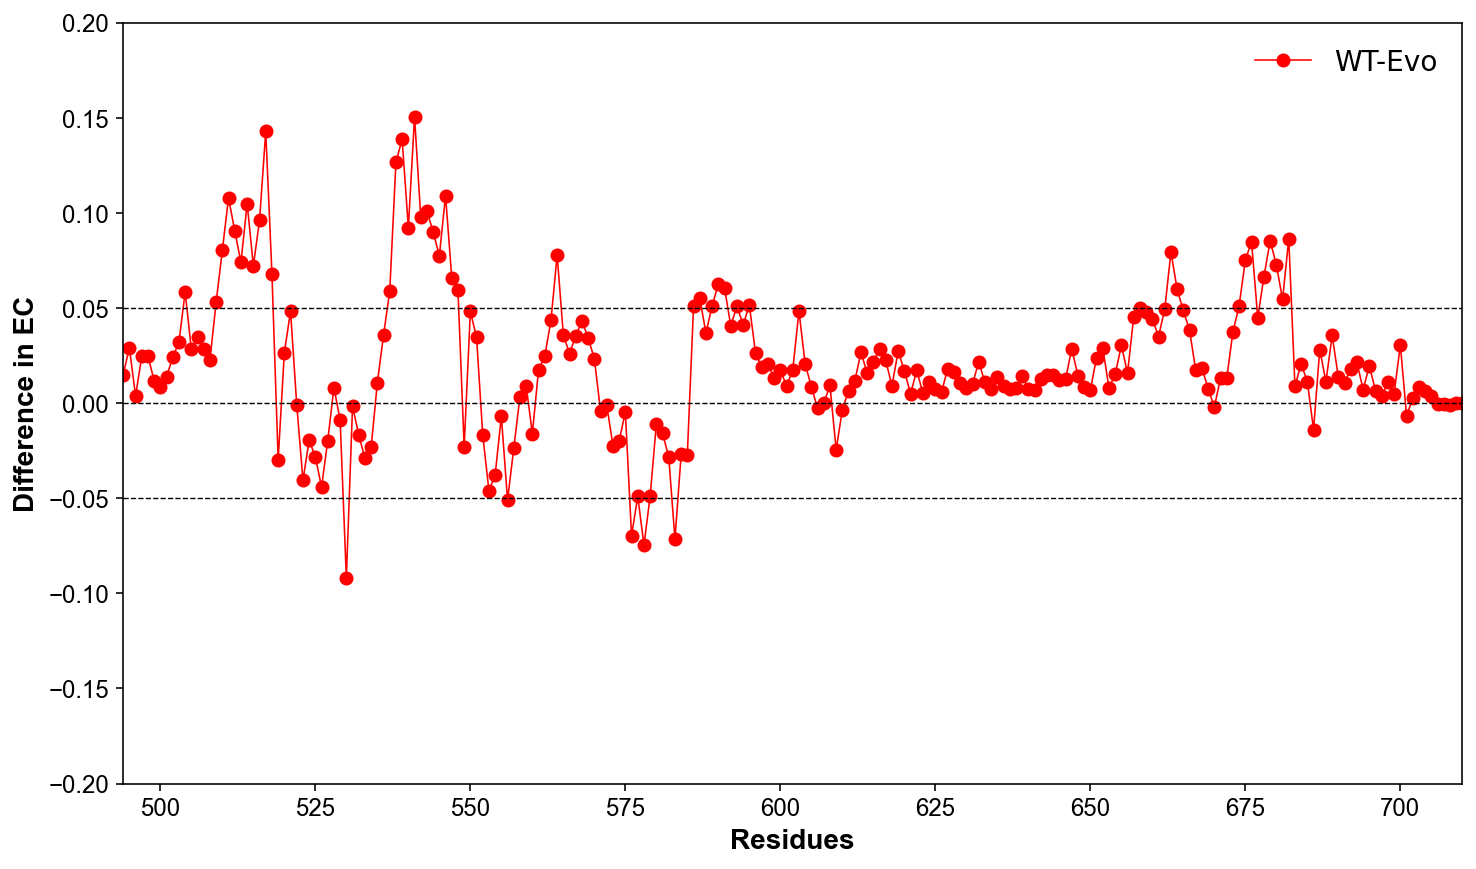

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
## Plotting
%matplotlib inline

#%config InlineBackend.figure_format = 'retina'  # high resolution
plt.figure(figsize=(12,7))
plt.plot(WT_Evo, '-o', alpha=1, color='red', linewidth=0.8, label='WT-Evo')
plt.plot([494, 710], [0.00, 0.00], 'k--', lw=0.7)
plt.plot([494, 710], [0.05, 0.05], 'k--', lw=0.7)
plt.plot([494, 710], [-0.05, -0.05], 'k--', lw=0.7)
# plt.plot(atg_tg, '-o', alpha=1, color='blue', linewidth=0.8, label='atgRNA-tgRNA')
plt.axis([494, 710, -0.2, 0.2])

plt.xlabel("Residues", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.ylabel("Difference in EC", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.xticks(fontname = 'Arial', fontsize = 12)
plt.yticks(fontname = 'Arial', fontsize = 12)
plt.legend(prop={"size":14}, frameon=False)
plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/Results/WT-Evo-network/WT-Evo_EC_systems.png", dpi=600)

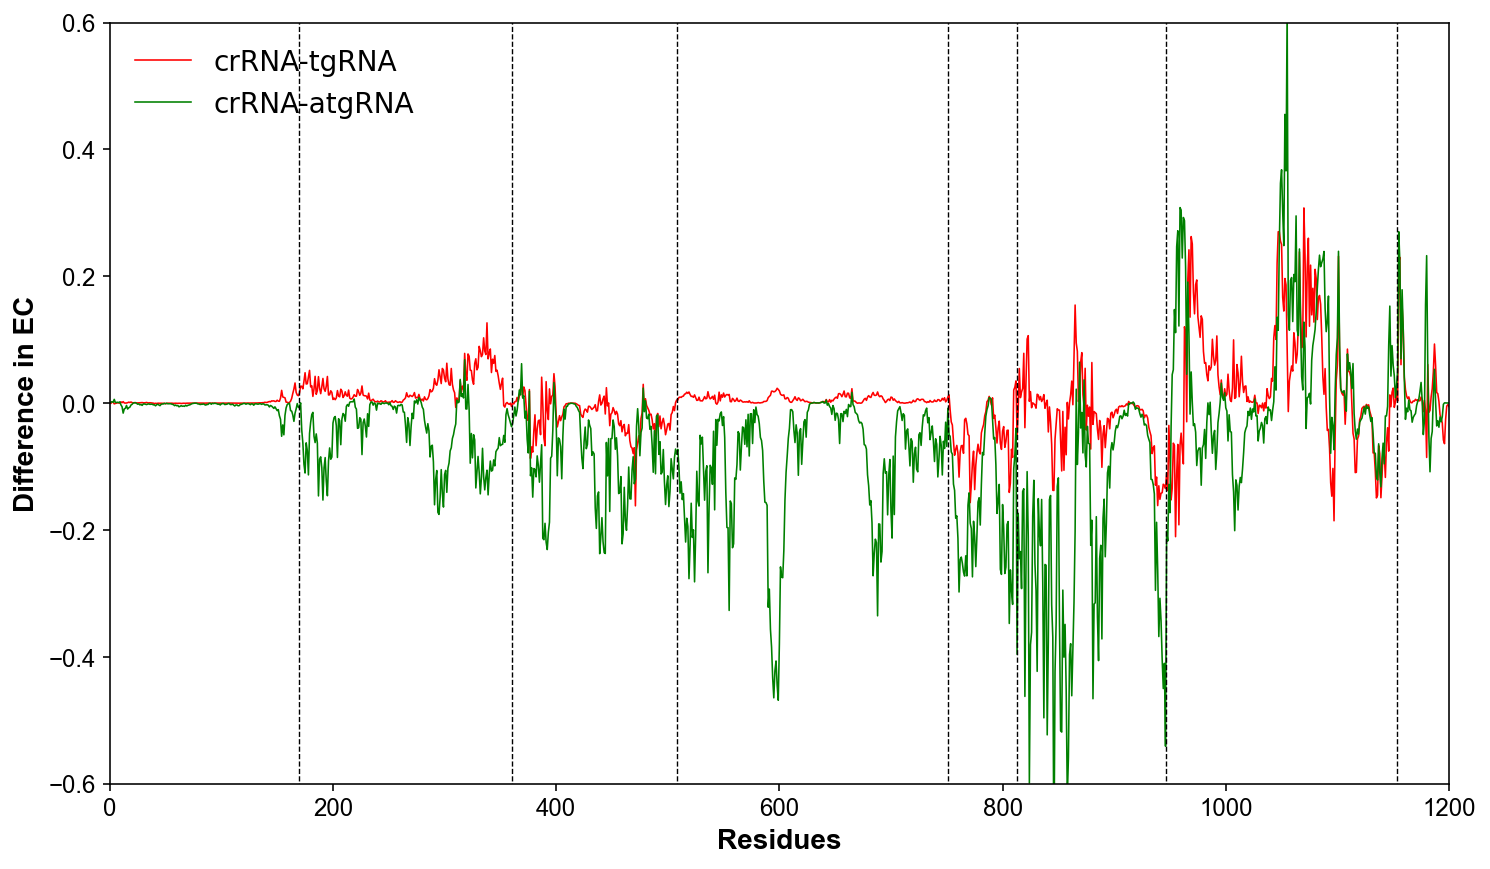

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
## Plotting
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'  # high resolution
plt.figure(figsize=(12,7))
plt.plot(cr_tg, alpha=1, color='red', linewidth=0.8, label='crRNA-tgRNA')
# plt.plot(atg_tg, alpha=1, color='blue', linewidth=0.8, label='atgRNA-tgRNA')
plt.plot(cr_atg, alpha=1, color='green', linewidth=0.8, label='crRNA-atgRNA')

plt.axis([0, 1200, -0.6, 0.6])
# Vertical Lines
plt.plot([170, 170], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([360, 360], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([508, 508], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([751, 751], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([813, 813], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([946, 946], [-0.75, 0.75], 'k--', lw=0.7)
plt.plot([1153, 1153], [-0.75, 0.75], 'k--', lw=0.7)
# plt.plot( [0, len(atg_tg)], [0.2, 0.2], 'k--', lw=0.6, color='green')
# plt.plot( [0, len(atg_tg)], [-0.2, -0.2], 'k--', lw=0.6, color='green')
plt.xlabel("Residues", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.ylabel("Difference in EC", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.xticks(fontname = 'Arial', fontsize = 12)
plt.yticks(fontname = 'Arial', fontsize = 12)
plt.legend(prop={"size":14}, frameon=False)
plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA/Cas13a-crRNA-EC-systems.png", dpi=600)

## Plotting of the signals and noise

In [9]:
import numpy as np
atg_6_8 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_pathlength6-8.dat')
atg_9_11 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_pathlength9-11.dat')
atg_12_14 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_pathlength12-14.dat')

atg_6_8_itoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength6-8_initTocatres.dat')
atg_9_11_itoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength9-11_initTocatres.dat')
atg_12_14_itoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength12-14_initTocatres.dat')

atg_6_8_swtoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength6-8_switchTocatres.dat')
atg_9_11_swtoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength9-11_switchTocatres.dat')
atg_12_14_swtoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength12-14_switchTocatres.dat')

atg_6_8_setoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength6-8_seedTocatres.dat')
atg_9_11_setoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength9-11_seedTocatres.dat')
atg_12_14_setoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength12-14_seedTocatres.dat')

# atg_9_11_swtoc = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/BCSum_sub&optlength9-11_switchTocatres.dat')



/var/folders/6n/3nqlb7m93wg2vxy4dg00ggzh0000gn/T/ipykernel_48394/3995617455.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


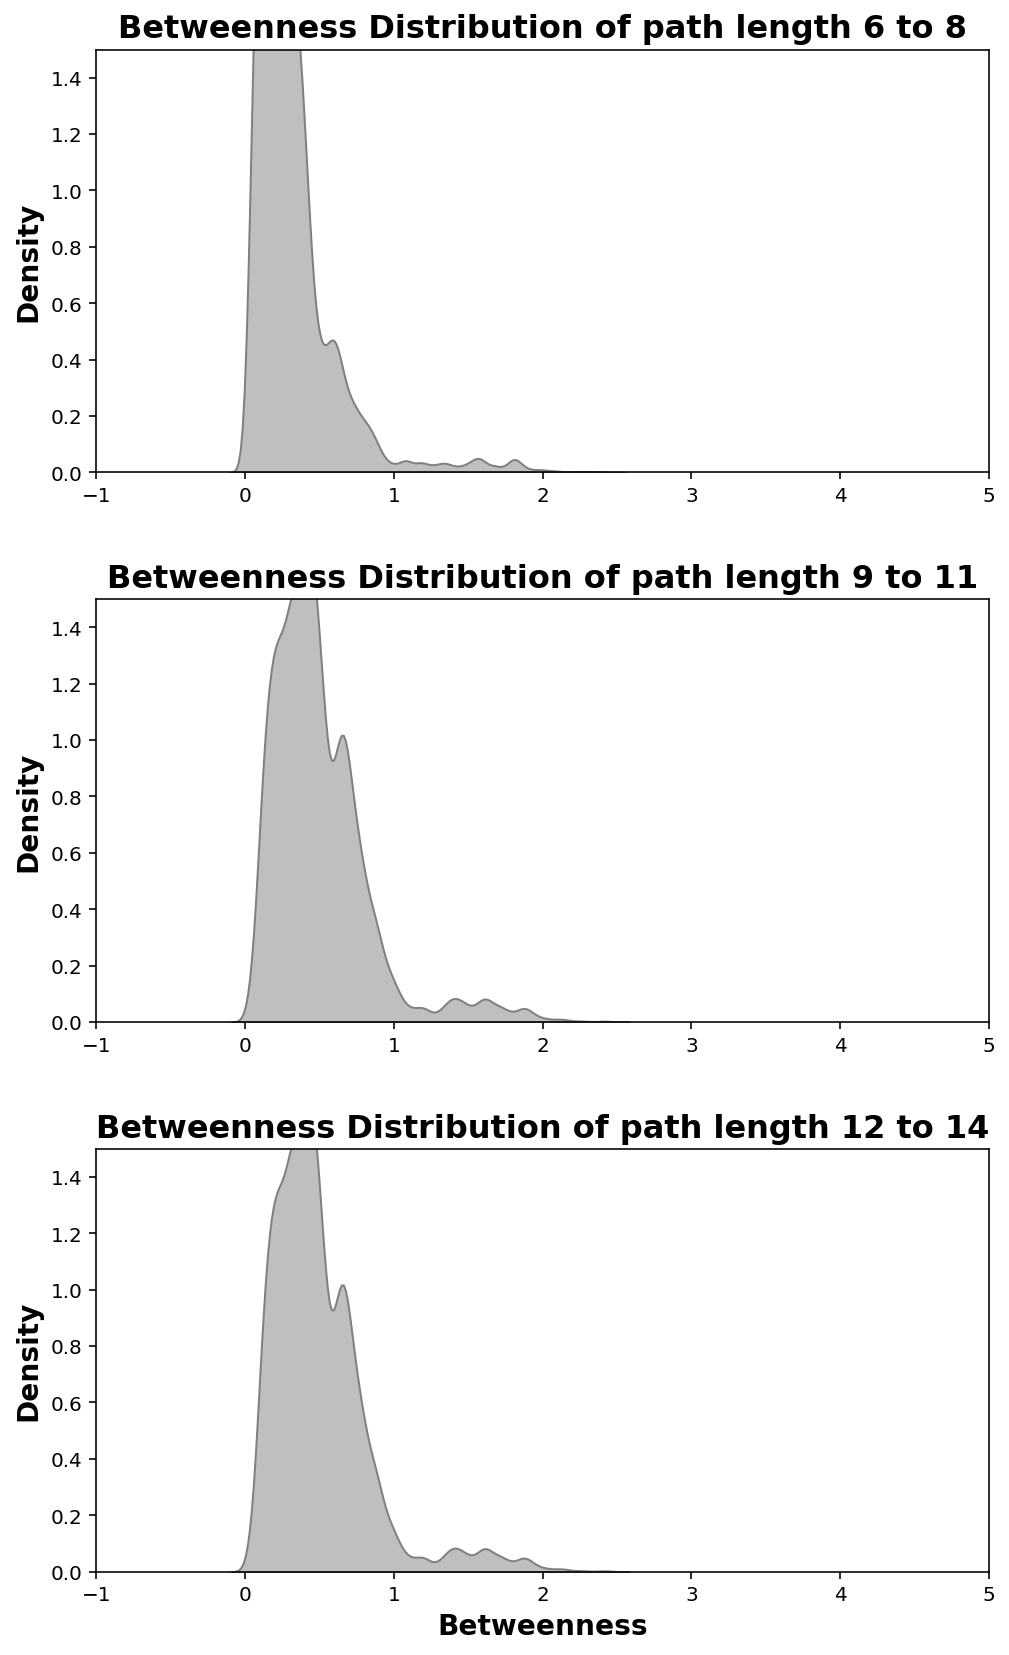

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
## Plotting
%matplotlib inline
fig = plt.figure(figsize=(8,14))
spec = gridspec.GridSpec(ncols=1, nrows=3, hspace=0.3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])

import seaborn as sb

sb.kdeplot(atg_6_8, color="grey", shade=True, alpha=0.5, ax=ax1, linewidth=1, label = 'atgRNA')
sb.kdeplot(atg_9_11, color="grey", shade=True, alpha=0.5, ax=ax2, linewidth=1, label = 'atgRNA')
sb.kdeplot(atg_9_11, color="grey", shade=True, alpha=0.5, ax=ax3, linewidth=1, label = 'atgRNA')
ax1.set_ylim([0, 1.5])
ax1.set_xlim([-1, 5])
ax1.set_title("Betweenness Distribution of path length 6 to 8", fontsize=16, fontweight='bold')
# ax1.scatter(atg_6_8_itoc,[0.40] * atg_6_8_itoc.shape[0],marker = "o", c="red")
# ax1.scatter(atg_6_8_swtoc,[0.80] * atg_6_8_swtoc.shape[0],marker = "o", c="green")
# ax1.scatter(atg_6_8_setoc,[1.20] * atg_6_8_setoc.shape[0],marker = "o", c="blue")
ax1.set_ylabel('Density', fontsize=14, fontweight='bold')

ax2.set_ylim([0, 1.5])
ax2.set_xlim([-1, 5])
ax2.set_title("Betweenness Distribution of path length 9 to 11", fontsize=16, fontweight='bold')
# ax2.scatter(atg_9_11_itoc,[0.40] * atg_9_11_itoc.shape[0],marker = "o", c="red")
# ax2.scatter(atg_9_11_swtoc,[0.80] * atg_9_11_swtoc.shape[0],marker = "o", c="green")
# ax2.scatter(atg_9_11_setoc,[1.20] * atg_9_11_setoc.shape[0],marker = "o", c="blue")
ax2.set_ylabel('Density', fontsize=14, fontweight='bold')

ax3.set_ylim([0, 1.5])
ax3.set_xlim([-1, 5])
ax3.set_title("Betweenness Distribution of path length 12 to 14", fontsize=16, fontweight='bold')
# ax3.scatter(atg_12_14_itoc,[0.40] * atg_12_14_itoc.shape[0],marker = "o", c="red")
# ax3.scatter(atg_12_14_swtoc,[0.80] * atg_12_14_swtoc.shape[0] ,marker = "o", c="green")
# ax3.scatter(atg_12_14_setoc,[1.20] * atg_12_14_setoc.shape[0],marker = "o", c="blue")
ax3.set_xlabel('Betweenness', fontsize=14, fontweight='bold') 
ax3.set_ylabel('Density', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/Noise_PathDistribution_all.png", dpi=600)
# plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/sub_opt_PathDistribution_all.png", dpi=600)

## Calculate SNR 

In [40]:
import numpy as np
from scipy.integrate import quad
from sklearn.neighbors import KernelDensity

def expectation(KDE):
    pdf = lambda x : np.exp(KDE.score_samples([[x]]))[0]
    mean_integration = quad(lambda x: x * pdf(x), a=-np.inf, b=np.inf)[0]
    variance_integration = quad(lambda x: (x ** 2) * pdf(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
    return mean_integration/variance_integration

    


kde_cr_6_8 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(cr_6_8[:, np.newaxis])
kde_cr_6_8_itoc = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(cr_6_8_itoc[:, np.newaxis])
kde_cr_6_8_swtoc = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(cr_6_8_swtoc[:, np.newaxis])
# kde_cr_6_8_setoc = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(cr_6_8_setoc[:, np.newaxis])


print("Expectation of cr_6_8 noise:", expectation(kde_cr_6_8))

print("Expectation of cr_6_8_itoc noise:", expectation(kde_cr_6_8_itoc))

print("Expectation of cr_6_8_swtoc noise:", expectation(kde_cr_6_8_swtoc))

# print("Expectation of cr_6_8_setoc noise:", expectation(kde_cr_6_8_setoc))

print("SNR cr_6_8_itoc:", expectation(kde_cr_6_8_itoc)/expectation(kde_cr_6_8))

print("SNR cr_6_8_swtoc:", expectation(kde_cr_6_8_swtoc)/expectation(kde_cr_6_8))

# print("SNR cr_6_8_setoc:", expectation(kde_cr_6_8_setoc)/expectation(kde_cr_6_8))



Expectation of cr_6_8 noise: 1.2177918278977045
Expectation of cr_6_8_itoc noise: 1.5286468268240638
Expectation of cr_6_8_swtoc noise: 2.3306190210540505
SNR cr_6_8_itoc: 1.2552611963762261
SNR cr_6_8_swtoc: 1.9138074075250113


In [56]:
# l = [0.25] * 10
# print(l)
print(cr_6_8_swtoc)

[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
0.8196927360054904


## Section to read graph and visualize network

In [1]:
import numpy as np
import pandas as pd

In [43]:
# interdomain_bet = np.genfromtxt("tgRNA/tgRNA-atgRNA_withTGRNA_InterDomain_betweenness.csv", delimiter=",")
interdomain_bet = np.genfromtxt("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA/run/Network_Analysis/crRNA/crRNA_networkData_InterDomain_betweenness.csv", delimiter=",")

print(interdomain_bet)
print(interdomain_bet.shape)

[[ 0.     2.661  2.374  9.993  0.     0.     1.811 10.204]
 [ 2.661  0.     3.074  0.636  0.     0.    19.995 28.225]
 [ 2.374  3.074  0.     6.095 43.173  9.41  20.204  5.393]
 [ 9.993  0.636  6.095  0.    23.493  1.226  0.     8.626]
 [ 0.     0.    43.173 23.493  0.     3.566  1.43   1.785]
 [ 0.     0.     9.41   1.226  3.566  0.    16.167  0.661]
 [ 1.811 19.995 20.204  0.     1.43  16.167  0.     4.006]
 [10.204 28.225  5.393  8.626  1.785  0.661  4.006  0.   ]]
(8, 8)


In [44]:
b = np.triu(interdomain_bet)
print(b)

[[ 0.     2.661  2.374  9.993  0.     0.     1.811 10.204]
 [ 0.     0.     3.074  0.636  0.     0.    19.995 28.225]
 [ 0.     0.     0.     6.095 43.173  9.41  20.204  5.393]
 [ 0.     0.     0.     0.    23.493  1.226  0.     8.626]
 [ 0.     0.     0.     0.     0.     3.566  1.43   1.785]
 [ 0.     0.     0.     0.     0.     0.    16.167  0.661]
 [ 0.     0.     0.     0.     0.     0.     0.     4.006]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]


In [45]:
node_names = ['NTD', 'Helical-1', 'HEPN1-I', 'Helical-2', 'HEPN1-II', 'Linker', 'HEPN2', 'crRNA']

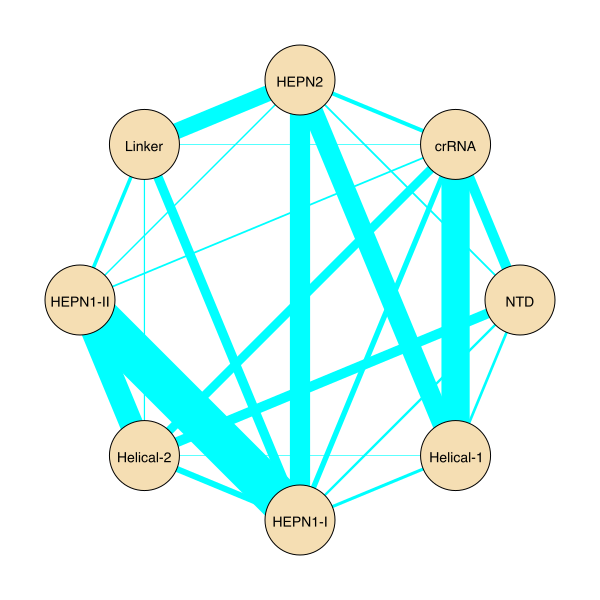

In [47]:
import matplotlib.pyplot as plt
# %matplotlib inline
# fig, ax = plt.subplots()
# ig.plot(g, target=ax)
import igraph as ig 
from igraph import *

# get the row, col indices of the non-zero elements in your adjacency matrix
conn_indices = np.where(b)

# get the weights corresponding to these indices
weights = b[conn_indices]

# a sequence of (i, j) tuples, each corresponding to an edge from i -> j
edges = zip(*conn_indices)

# initialize the graph from the edge sequence
G = ig.Graph(edges=edges, directed=False)

color_list = []
for i in weights:
    if i < 0:
        color_list.append('red')
    else:
        color_list.append('cyan')
# assign node names and weights to be attributes of the vertices and edges
# respectively
G.vs['label'] = node_names
G.es['color'] = color_list
G.es['weight'] = np.absolute(weights)

# G.es['color'] = color_list

# I will also assign the weights to the 'width' attribute of the edges. this
# means that igraph.plot will set the line thicknesses according to the edge
# weights
G.es['width'] = np.absolute(weights)



# plot the graph, just for fun
# igraph.plot(G, layout="rt", labels=True, margin=80, target=ax)
layout = G.layout("circle")
visual_style = {}
visual_style["vertex_size"] = 70
visual_style["vertex_color"] = "wheat"
visual_style["labels"] = True
visual_style["margin"] = 80
visual_style["layout"] = layout

# ig.plot(G, vertex_size=70, vertex_color="wheat", layout=layout, labels=True, margin=80)
ig.plot(G,"tgRNA/crRNA_networkData_InterDomain_betweenness.png", **visual_style)

In [24]:
# print(weights)
# print(np.absolute(weights))
# color_list = []
# for i in weights:
#     if i < 0:
#         color_list.append('red')
#     else:
#         color_list.append('cyan')
# print(color_list)
# # color_dict = {"-ve": "cyan", "+ve": ""}

# ---- The End ----